In [3]:
!pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd

df = pd.read_csv('../data/raw/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
# Descriptive statistics
df.describe()

# Missing values
df.isnull().sum()


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Children Variable Analysis

<Axes: xlabel='children', ylabel='charges'>

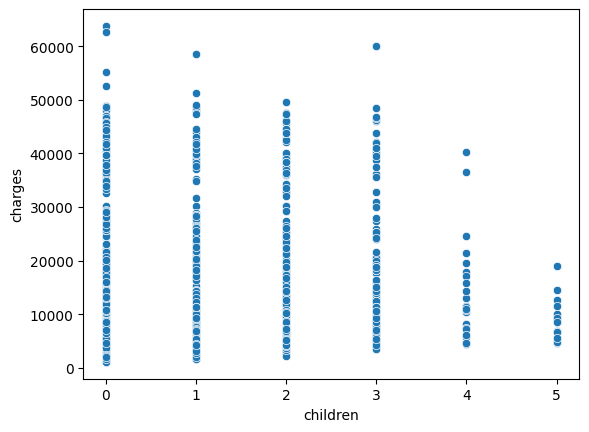

In [8]:
import seaborn as sns
sns.scatterplot(x='children', y='charges', data=df)

In [9]:
import numpy as np

df['log_charge'] = np.log(df['charges'])

R-squared (Numerical children): 0.5214792064671386
R-squared (Categorical children): 0.8060419975620804


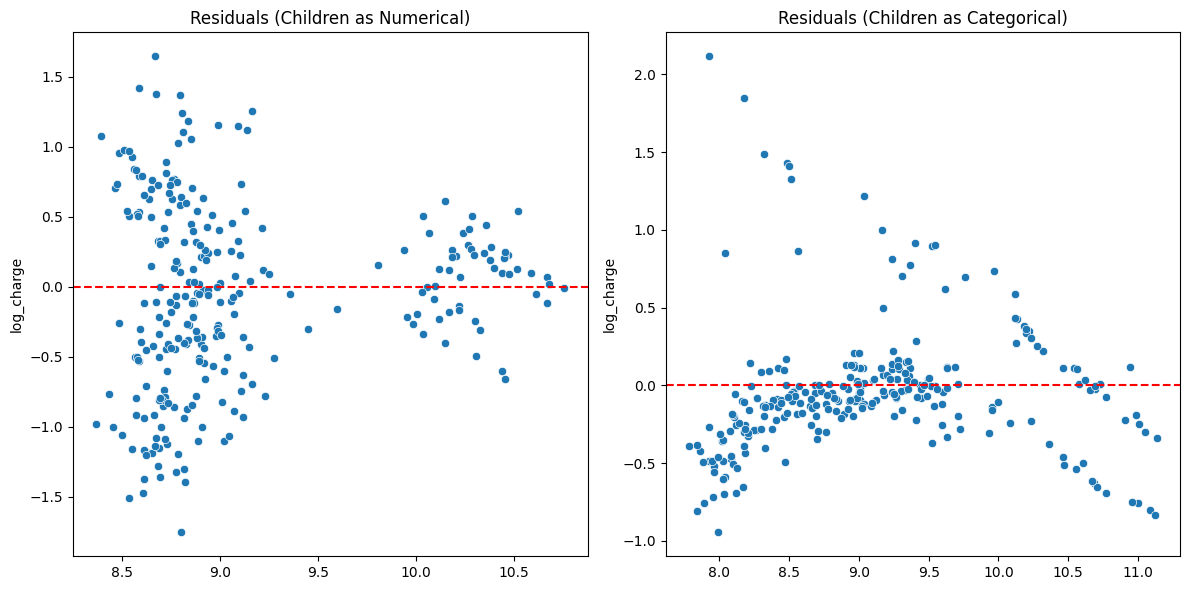

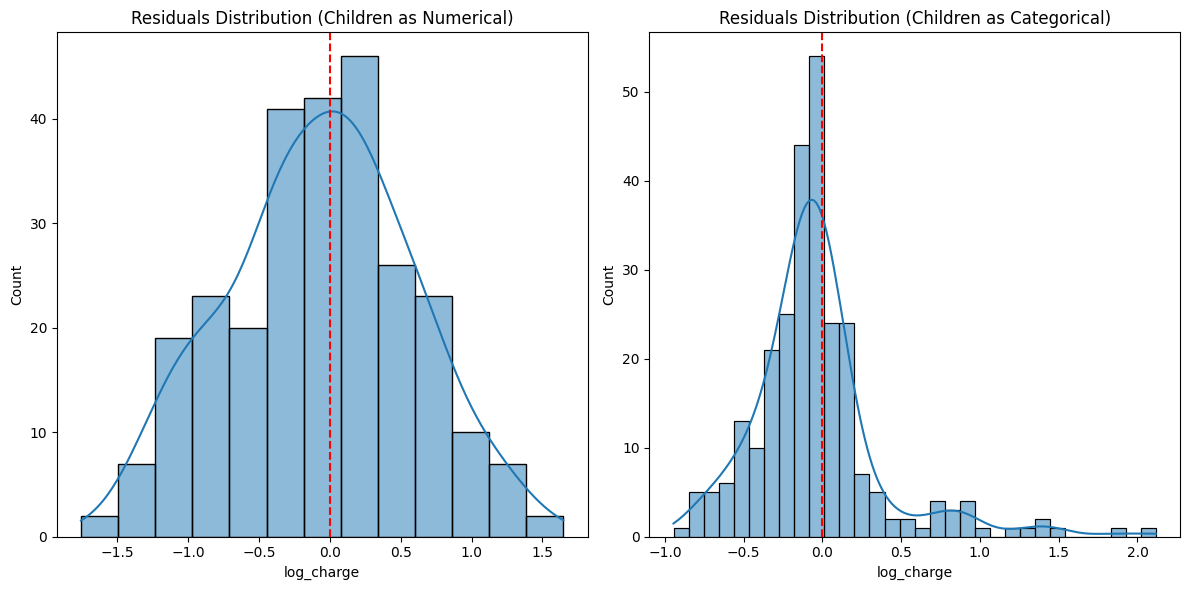

In [10]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Model 1: Children as Numerical Variable
X_numerical = df[['bmi', 'children', 'smoker', 'region', 'sex']]
X_numerical = pd.get_dummies(X_numerical, drop_first=True)
X_numerical = X_numerical.astype(float)

# Model 2: Children as Categorical Variable (One-Hot Encoded)
X_categorical = df[['age', 'bmi', 'smoker', 'region', 'sex']]
X_categorical = pd.get_dummies(X_categorical, drop_first=True)
X_categorical = pd.concat([X_categorical, pd.get_dummies(df['children'], prefix='children', drop_first=True)], axis=1)

y= df['log_charge']
# Split the data for both models
X_train_num, X_test_num, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42)
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_categorical, y, test_size=0.2, random_state=42)

# Fit both models
linear_model_num = LinearRegression().fit(X_train_num, y_train)
linear_model_cat = LinearRegression().fit(X_train_cat, y_train)

# Predict on the test set for both models
y_pred_num = linear_model_num.predict(X_test_num)
y_pred_cat = linear_model_cat.predict(X_test_cat)

# Compare performance (R-squared)
r2_num = r2_score(y_test, y_pred_num)
r2_cat = r2_score(y_test, y_pred_cat)

print(f"R-squared (Numerical children): {r2_num}")
print(f"R-squared (Categorical children): {r2_cat}")

# Residual plots
plt.figure(figsize=(12, 6))

# Residuals for Numerical
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_num, y=(y_test - y_pred_num))
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals (Children as Numerical)')

# Residuals for Categorical
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_pred_cat, y=(y_test - y_pred_cat))
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals (Children as Categorical)')

plt.tight_layout()
plt.show()
# Assume residuals have been computed as:
residuals_num = y_test - y_pred_num # (for children as numerical)
residuals_cat = y_test - y_pred_cat # (for children as categorical)

# Create distribution plots
plt.figure(figsize=(12, 6))

# Plot residuals for numerical children
plt.subplot(1, 2, 1)
sns.histplot(residuals_num, kde=True)
plt.title('Residuals Distribution (Children as Numerical)')
plt.axvline(0, color='red', linestyle='--')

# Plot residuals for categorical children
plt.subplot(1, 2, 2)
sns.histplot(residuals_cat, kde=True)
plt.title('Residuals Distribution (Children as Categorical)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [11]:
coefficients = pd.DataFrame({
    'Feature': X_numerical.columns,
    'Coefficient': linear_model_num.coef_
})
coefficients

,Feature,Coefficient
0,bmi,0.023832
1,children,0.116671
2,smoker_yes,1.493063
3,region_northwest,-0.036224
4,region_southeast,-0.170948
5,region_southwest,-0.106748
6,sex_male,-0.082394


we can already see some structure in the residuals, this would imply that the model is not accounting for all variance of the data

In [12]:
import statsmodels.api as sm

# Step 1: Fit an OLS model to estimate residuals
X_ols = sm.add_constant(X_numerical)  # Adding a constant term for the intercept
ols_model = sm.OLS(y, X_ols).fit()

# Get the residuals from the OLS model
residuals = ols_model.resid

# Step 2: Calculate weights (inverse of squared residuals)
weights = 1 / (residuals ** 2)

# Step 3: Fit a WLS model using the weights
wls_model = sm.WLS(y, X_ols, weights=weights).fit()

# Step 4: Print the summary of the WLS model
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:             log_charge   R-squared:                       0.994
Model:                            WLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.435e+04
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:03:13   Log-Likelihood:                -506.52
No. Observations:                1338   AIC:                             1029.
Df Residuals:                    1330   BIC:                             1071.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.1088      0.007  

In [13]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pandas as pd

# Model 1: Children as Numerical Variable
X_numerical = df[['bmi','age', 'children', 'smoker', 'region', 'sex']]
X_numerical = pd.get_dummies(X_numerical, drop_first=True)  # One-hot encode categorical variables
X_numerical = X_numerical.astype(float)  # Ensure features are float
y = df['log_charge']  # Target variable (log of charges)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=0.2, random_state=42)

### Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

### XGBoost Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

### WLS Model
# Step 1: Add a constant to the training data for OLS
X_train_ols = sm.add_constant(X_train)  # Adding a constant term for the intercept

# Step 2: Fit an OLS model to estimate residuals
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Get the residuals from the OLS model
residuals = ols_model.resid

# Step 3: Calculate weights (inverse of squared residuals)
weights = 1 / (residuals ** 2)

# Step 4: Fit a WLS model using the weights
wls_model = sm.WLS(y_train, X_train_ols, weights=weights).fit()

# Step 5: For predictions, ensure the test set also has a constant
X_test_ols = sm.add_constant(X_test)
y_pred_wls = wls_model.predict(X_test_ols)

### Evaluate all three models
def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} Results:")
    print(f"R-squared: {r2}")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}\n")
    
# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Evaluate WLS
evaluate_model(y_test, y_pred_wls, "WLS")


Random Forest Results:
R-squared: 0.8455990429746808
Mean Squared Error: 0.1388281789687114
Mean Absolute Error: 0.1962902761390815

XGBoost Results:
R-squared: 0.8479419219179556
Mean Squared Error: 0.136721601240792
Mean Absolute Error: 0.1942699048728763

WLS Results:
R-squared: 0.8050031953185603
Mean Squared Error: 0.17532955637187245
Mean Absolute Error: 0.2668657209575692



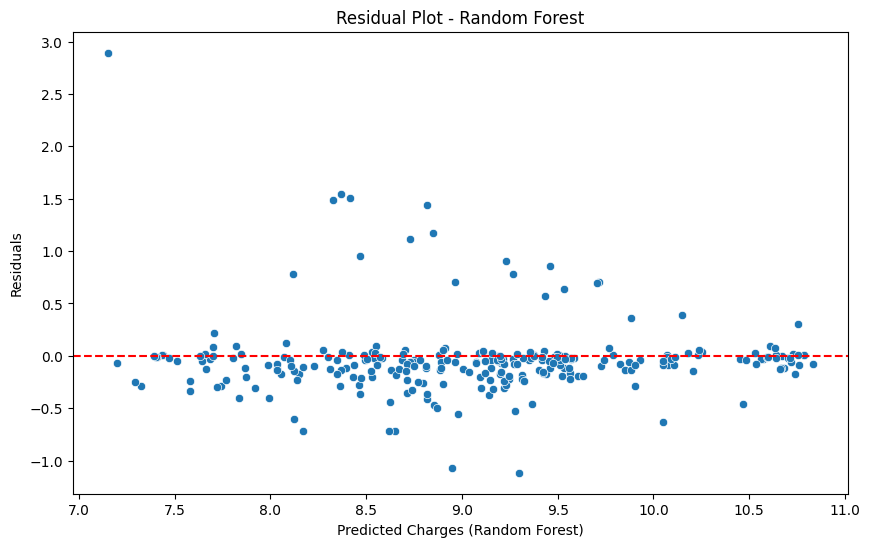

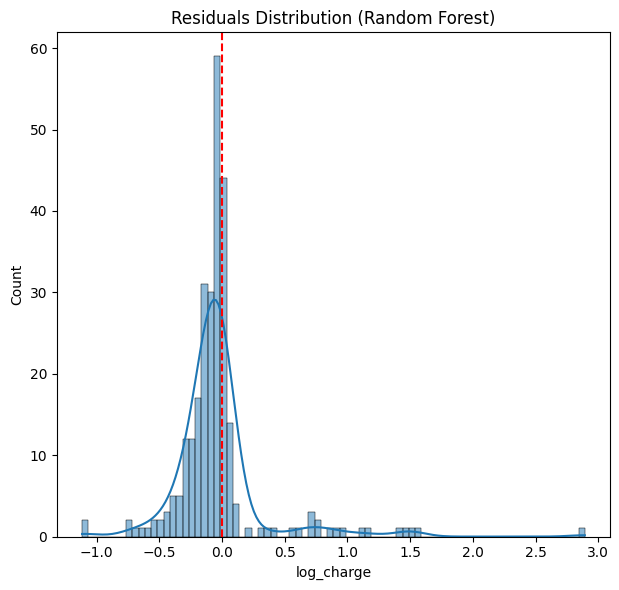

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals for Random Forest
residuals_rf = y_test - y_pred_rf

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_rf, y=residuals_rf)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Charges (Random Forest)')
plt.ylabel('Residuals')
plt.title('Residual Plot - Random Forest')
# plt.savefig('images/residuals_random_forest.png')
plt.show()
plt.figure(figsize=(12, 6))

# Plot residuals for numerical children
plt.subplot(1, 2, 1)
sns.histplot(residuals_rf, kde=True)
plt.title('Residuals Distribution (Random Forest)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

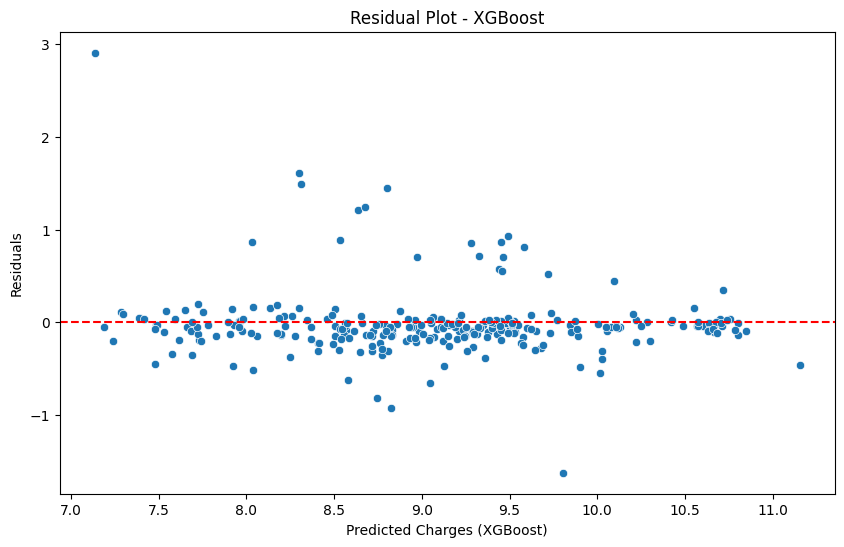

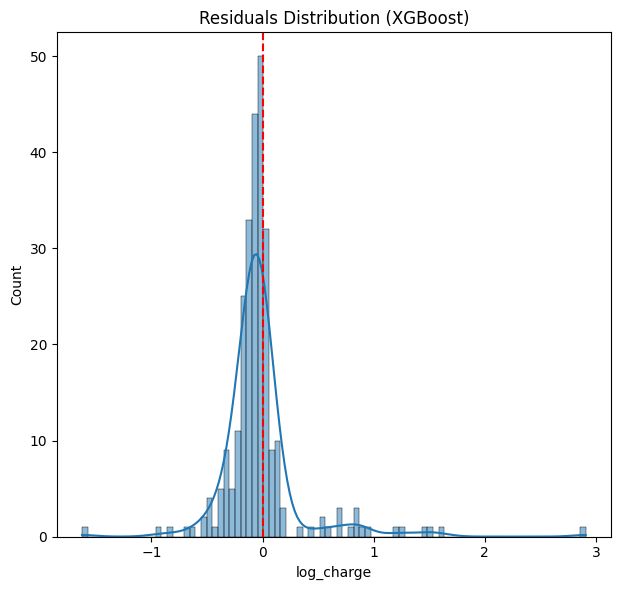

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals for Random Forest
residuals_xgb = y_test - y_pred_xgb

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Charges (XGBoost)')
plt.ylabel('Residuals')
plt.title('Residual Plot - XGBoost')
# plt.savefig('images/residuals_random_forest.png')
plt.show()
plt.figure(figsize=(12, 6))

# Plot residuals for numerical children
plt.subplot(1, 2, 1)
sns.histplot(residuals_xgb, kde=True)
plt.title('Residuals Distribution (XGBoost)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

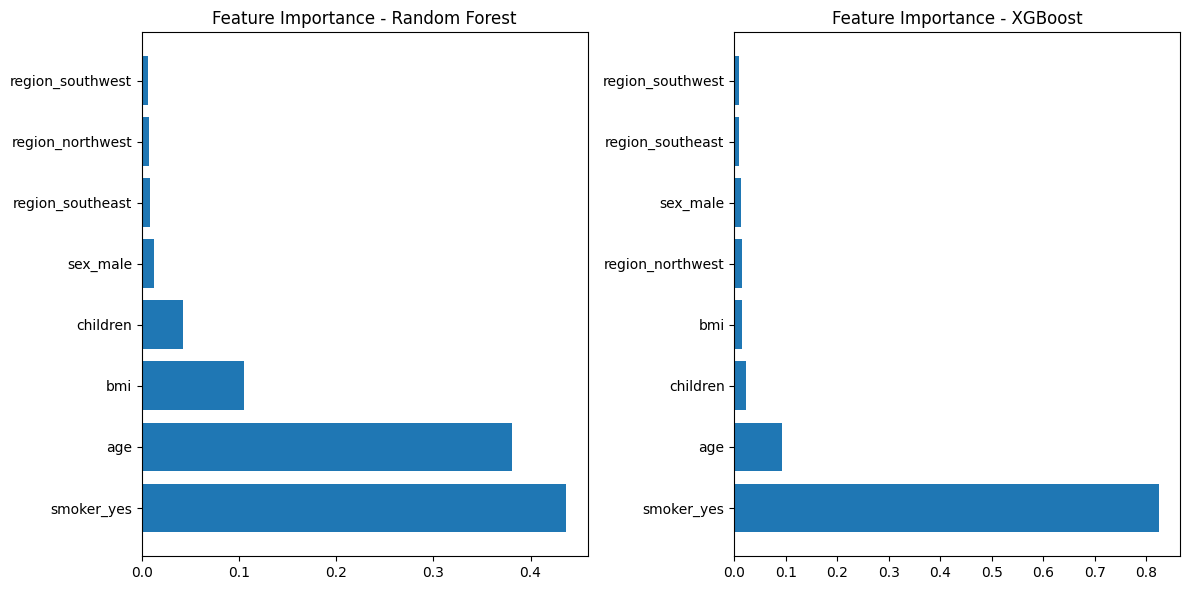

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Feature importance for Random Forest
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

# Plot feature importance
features = X_numerical.columns
indices_rf = np.argsort(rf_importances)[::-1]
indices_xgb = np.argsort(xgb_importances)[::-1]

plt.figure(figsize=(12, 6))

# Random Forest
plt.subplot(1, 2, 1)
plt.title("Feature Importance - Random Forest")
plt.barh(range(len(indices_rf)), rf_importances[indices_rf], align='center')
plt.yticks(range(len(indices_rf)), [features[i] for i in indices_rf])

# XGBoost
plt.subplot(1, 2, 2)
plt.title("Feature Importance - XGBoost")
plt.barh(range(len(indices_xgb)), xgb_importances[indices_xgb], align='center')
plt.yticks(range(len(indices_xgb)), [features[i] for i in indices_xgb])

plt.tight_layout()
plt.show()


In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Random Forest Hyperparameter Tuning
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']  # Replaced 'auto' with valid options
}

rf_model = RandomForestRegressor(random_state=42)
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

print(f"Best parameters for Random Forest: {rf_grid_search.best_params_}")
print(f"Best score for Random Forest: {rf_grid_search.best_score_}")

# XGBoost Hyperparameter Tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBRegressor(random_state=42)
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=5, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train, y_train)

print(f"Best parameters for XGBoost: {xgb_grid_search.best_params_}")
print(f"Best score for XGBoost: {xgb_grid_search.best_score_}")


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Best score for Random Forest: 0.8167143398723619
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.6}
Best score for XGBoost: 0.8194386339754475


In [53]:
# Best model from Random Forest
best_rf_model = rf_grid_search.best_estimator_

# Best model from XGBoost
best_xgb_model = xgb_grid_search.best_estimator_


In [56]:
import joblib

# Save Random Forest best model
joblib.dump(best_rf_model, '../model/best_rf_model.pkl')

# Save XGBoost best model
joblib.dump(best_xgb_model, '../model/best_xgb_model.pkl')


['../model/best_xgb_model.pkl']

In [59]:
import joblib

model = joblib.load('../model/best_xgb_model.pkl')
best_rf_model = joblib.load('../model/best_xgb_model.pkl')


In [51]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Get the best models from the grid search
best_rf_model = rf_grid_search.best_estimator_
best_xgb_model = xgb_grid_search.best_estimator_

# Predict on the test set using the best models
y_pred_rf = best_rf_model.predict(X_test)
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the Random Forest model
def evaluate_model(y_test, y_pred, model_name):
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} Results:")
    print(f"R-squared: {r2}")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}\n")

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Best Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "Best XGBoost")

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [49]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe for VIF calculation (exclude the constant)
# X_vif = X_numerical.drop(columns=['const'])
vif = pd.DataFrame()
vif['Variable'] = X_numerical.columns
vif['VIF'] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]
print(vif)


           Variable        VIF
0               age   7.686965
1               bmi  11.358443
2          children   1.809930
3        smoker_yes   1.261233
4  region_northwest   1.890281
5  region_southeast   2.265564
6  region_southwest   1.960745
7          sex_male   2.003185


## Checking for highly correlated variables with the target variable

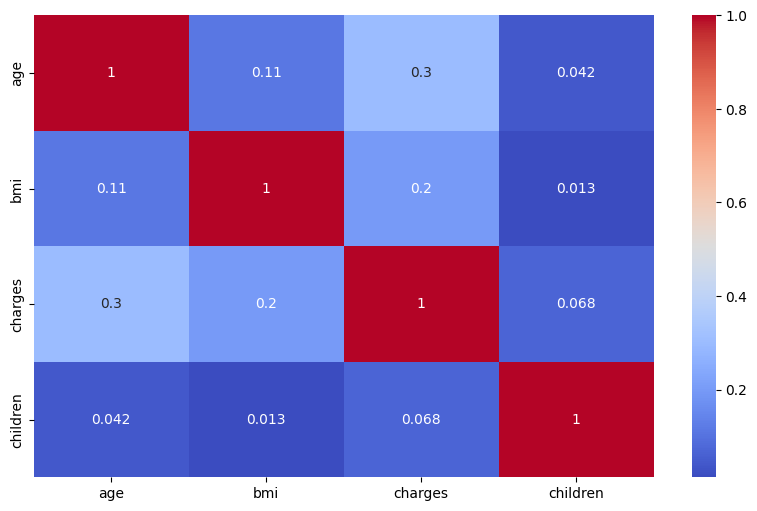

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix to see how features relate to the target (charges)
corr_matrix = df[['age','bmi','charges','children']].corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [47]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA to assess the significance of the 'region' variable
# We use the 'charges' as the dependent variable and 'region' as the factor
model = ols('charges ~ region', data=df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table  # Display the ANOVA results

,sum_sq,df,F,PR(>F)
region,1.300760e+09,3.0,2.969627,0.030893
Residual,1.947735e+11,1334.0,NaN,NaN


In [46]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA to assess the significance of the 'region' variable
# We use the 'charges' as the dependent variable and 'region' as the factor
model = ols('charges ~ sex', data=df).fit()

# Perform ANOVA
anova_table_sex = sm.stats.anova_lm(model, typ=2)

anova_table_sex  # Display the ANOVA results


,sum_sq,df,F,PR(>F)
sex,6.435902e+08,1.0,4.399702,0.036133
Residual,1.954306e+11,1336.0,NaN,NaN


In [23]:
df.groupby('sex')['charges'].agg(['mean', 'median', 'std'])

,mean,median,std
sex,,,
female,12569.578844,9412.96250,11128.703801
male,13956.751178,9369.61575,12971.025915


In [24]:
df.groupby('smoker')['charges'].agg(['mean', 'median', 'std'])

,mean,median,std
smoker,,,
no,8434.268298,7345.40530,5993.781819
yes,32050.231832,34456.34845,11541.547176


In [25]:
df.groupby('region')['charges'].agg(['mean', 'median', 'std'])

,mean,median,std
region,,,
northeast,13406.384516,10057.652025,11255.803066
northwest,12417.575374,8965.795750,11072.276928
southeast,14735.411438,9294.131950,13971.098589
southwest,12346.937377,8798.593000,11557.179101


In [26]:
correlation_age_charges = df['age'].corr(df['charges'])
correlation_bmi_charges = df['bmi'].corr(df['charges'])
correlation_children_charges = df['children'].corr(df['charges'])

print(f"Correlation between Age and Charges: {correlation_age_charges}")
print(f"Correlation between BMI and Charges: {correlation_bmi_charges}")
print(f"Correlation between number of Children and Charges: {correlation_children_charges}")


Correlation between Age and Charges: 0.29900819333064776
Correlation between BMI and Charges: 0.1983409688336289
Correlation between number of Children and Charges: 0.06799822684790487


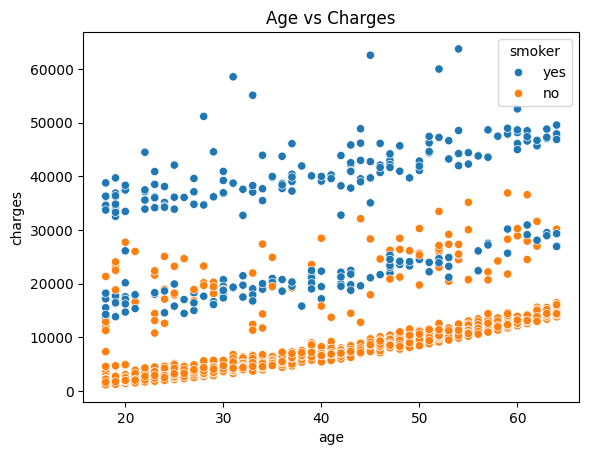

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for age vs. charges
sns.scatterplot(x='age', y='charges',hue='smoker' ,data=df)
plt.title('Age vs Charges')
plt.show()


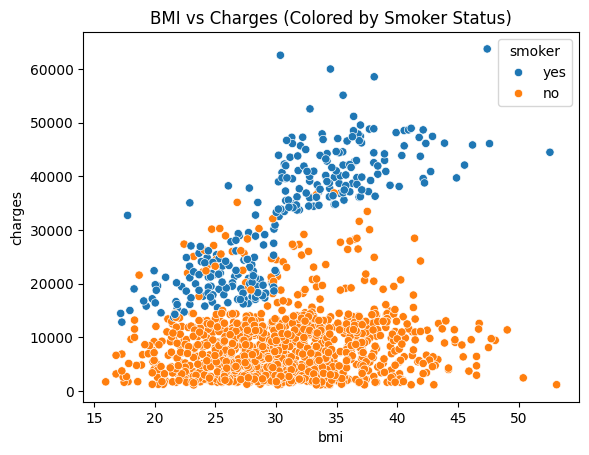

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for age vs. charges
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)
plt.title('BMI vs Charges (Colored by Smoker Status)')
plt.show()


In [45]:
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split

# Prepare the data (use log-transformed charges as your target)
X_glm = df[['age', 'bmi', 'children', 'smoker', 'region', 'sex']]
X_glm = pd.get_dummies(X_glm, drop_first=True)  # Encode categorical features
y_glm = df['log_charge']  # Log-transformed target variable
X_glm = X_glm.astype(float)


# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_glm, y_glm, test_size=0.2, random_state=42)


# Add a constant term (intercept) for the GLM model
X_glm = sm.add_constant(X_glm)

# Fit the GLM model with Gaussian family (normal distribution) - adjust this based on your target
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
glm_results = glm_model.fit()

# Print summary
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             log_charge   No. Observations:                 1070
Model:                            GLM   Df Residuals:                     1062
Model Family:                Gaussian   Df Model:                            7
Link Function:               Identity   Scale:                          1.6181
Method:                          IRLS   Log-Likelihood:                -1771.7
Date:                Mon, 21 Oct 2024   Deviance:                       1718.4
Time:                        20:52:30   Pearson chi2:                 1.72e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            -0.6151
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
age                  0.0651      0.003  

In [43]:
# Define evaluation function
def evaluate_glm(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"R-squared: {r2}")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")

y_pred_glm_test = glm_results.predict(X_test)
# Evaluate the GLM model on the test set
evaluate_glm(y_test, y_pred_glm_test)

R-squared: -0.704772015790003
Mean Squared Error: 1.5328298416578816
Mean Absolute Error: 0.985015775691436


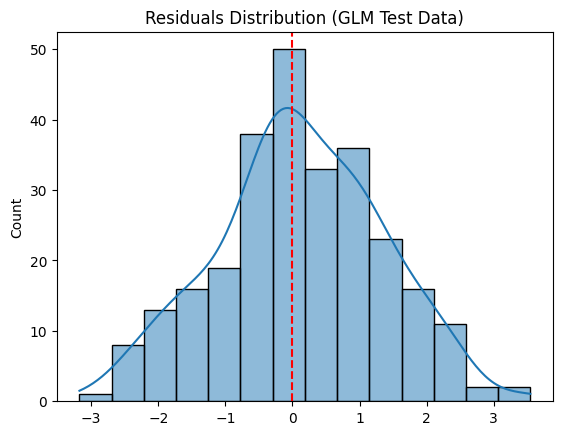

In [44]:
# Calculate residuals on test data
residuals_glm = y_test - y_pred_glm_test

# Plot residuals to check for patterns
sns.histplot(residuals_glm, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Residuals Distribution (GLM Test Data)")
plt.show()